# Diabetes Dataset Process and Results
Nathaniel Richards - 10/23/18

From UCI ML Repository    
["Diabetes 130-US hospitals for years 1999-2008 Data Set"](https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008#)

**Goal**: build model(s) to predict which patients will be re-hospitalized within 30 days

**Evaluate**: using AUROC

Notes:
- 'encounter_id' - unique admissions
- ignore 'patient_nbr' - treat all encounters independent
- 'readmitted' - treat 'NO' as '>30'
- Attributes: 55
- Samples: >100k
- Features: numerical, categorical

## Basic Approach

1. Exploration
    1. feature names
    1. feature types
    1. missing values
    1. numerical histograms
    1. categorical value counts
1. Preprocessing
    1. drop rows
        - missing data
        - other insights from exploration
    1. recode categorical features
        - reduce dimensionality
    1. convert types
        - numerical to categorical
        - categorical to numerical
    1. determine feature subset
    1. upsampling / downsampling
    1. train / validation / test split
1. Modeling
    1. Baseline models
        - logistic regression
        - SVC
    1. Advanced models
        - DNN w/ categorical embedding

## Considerations

1. Imbalanced classes
    - <30 only accounts for 11% of data
1. Upsampling / downsampling
    - Must be careful if upsampling, risk of information leakage between train/test
1. Train / val / test split
    - Ensure no information leakage, otherwise overly optimistic results

## Literature Survey

After planning out how I would approach this problem, I did some research on how others have performed on this open-source dataset.  Listed below are some articles that I found, including my inspiration and comments.

### [How to use machine learning to predict hospital readmissions?](https://medium.com/@uraza/how-to-use-machine-learning-to-predict-hospital-readmissions-part-1-bd137cbdba07)   
by Usman Raza

Reported test accuracy: 94%

Notes
- remove weight, payer_code, medical_specialty
- recode diagnoses {1,2,3}
- group similar admission/discharge categories
- convert age ranges to numerical mean
- drop subjects' second, third, etc visits

Pros
- extremely thorough set of blog posts
- insightful feature engineering/reduction
- references the paper associated with dataset
- uses pandas
- strong statistical background

Cons
- **overinflated train/test performance**

Why? Because of the way he performed upsampling.  He performed SMOTE upsampling *before* the train/test split, causing much of the training data information to end up in the test set.  This is how he was able to achieve such a high accuracy/AUROC compared to other literature.


### [STATS701 Project](https://jrfarrer.github.io/stat701_miniproject/)
by Jordan Farrer

Reported AUROC: <0.64

Notes
- confirms that modeling is difficult/impossible with such unbalanced classes

Pros
- great visualization, exploration

Cons
- did not perform upsampling/downsampling, left classes unbalanced
- poor model performance as a result
- similar performance to naive model (only predicting one class)
- unbalanced confusion matrix


### [Predicting Hospital Readmission for Patients with Diabetes Using Scikit-Learn](https://towardsdatascience.com/predicting-hospital-readmission-for-patients-with-diabetes-using-scikit-learn-a2e359b15f0)
by Andrew Long

Reported AUROC: ~0.65

Notes
- recode medical_specialty categories
- most weight values missing, but adds feature 'has_weight' as presence of weight record
- many models evaluated
- reports AUC
- performs hyperparameter optimization

Pros
- follows clear data science process
- train / val / test split
- properly performs subsampling after train/val split
- performs continuous feature scaling

Cons
- one-hot encoding? - may not be negative


## Other Resources

### [The Right Way to Oversample in Predictive Modeling](https://beckernick.github.io/oversampling-modeling/)
by Nick Becker

This article details the subtle-yet-dangerous pitfall of performing upsampling incorrectly.  One should apply SMOTE upsampling *after* the train/test split, otherwise information will leak between the train/test sets, resulting in inflated performance - the model has already trained on the data in the test set.

### [Building A Logistic Regression in Python, Step by Step](https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8)
by Susan Li

- Converts categorical features to one-hot
- Performs SMOTE on one-hot
- Properly performs SMOTE on train set after train/test split
- Recursive feature elimination (RFE)

## Expectations

I first came upon the results from [Usman Raza](https://medium.com/@uraza/how-to-use-machine-learning-to-predict-hospital-readmissions-part-1-bd137cbdba07) that reported 94% test accuracy on the Diabetes dataset.

However, these results were inflated (see above), and other results show an average test performance around AUC=0.65 .  In my model evaluation, this is my target to meet or exceed.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [20]:
import numpy as np
import pandas as pd
import os
import sys
import pprint

import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns
plt.style.use('ggplot')
sns.set()
# plt.style.use('seaborn')
mpl.style.use('seaborn')

pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.max_columns = 999
pd.options.display.max_rows = 500
np.set_printoptions(precision=6)

DATA_PATH = '../data'
RESULTS_PATH = '../results/00_baseline/'
pp = pprint.PrettyPrinter(indent=4)

print(pd.__version__)

# UGLY HACK - not for production
sys.path.append('..')

0.23.4


# Model Architecture

In [21]:
import utils

model = utils.load_model(RESULTS_PATH + 'model.pt')
display(model)

Network(
  (embeddings): ModuleList(
    (0): Embedding(6, 3)
    (1): Embedding(2, 1)
    (2): Embedding(4, 2)
    (3): Embedding(22, 11)
    (4): Embedding(15, 8)
    (5): Embedding(9, 5)
    (6): Embedding(10, 5)
    (7): Embedding(10, 5)
    (8): Embedding(4, 2)
    (9): Embedding(4, 2)
    (10): Embedding(4, 2)
    (11): Embedding(4, 2)
    (12): Embedding(4, 2)
    (13): Embedding(4, 2)
    (14): Embedding(4, 2)
    (15): Embedding(4, 2)
    (16): Embedding(2, 1)
    (17): Embedding(2, 1)
  )
  (dropout_emb): Dropout(p=0.5)
  (bn_continuous): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_layers): ModuleList(
    (0): FCUnit(
      (linear): Linear(in_features=67, out_features=512, bias=True)
      (batchnorm): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.5)
    )
    (1): FCUnit(
      (linear): Linear(in_features=512, out_features=256, bias=True)
      (batchnorm): BatchNorm1d

# Model Training

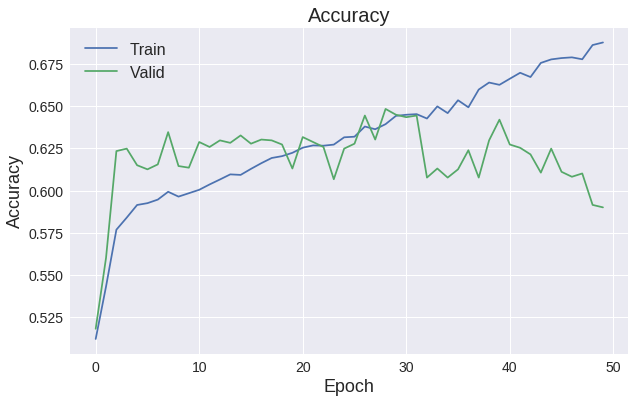

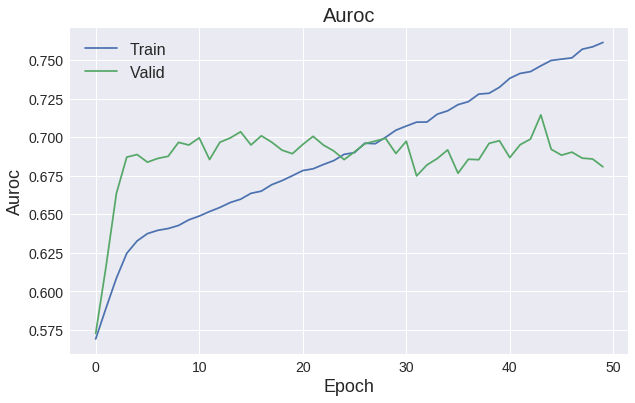

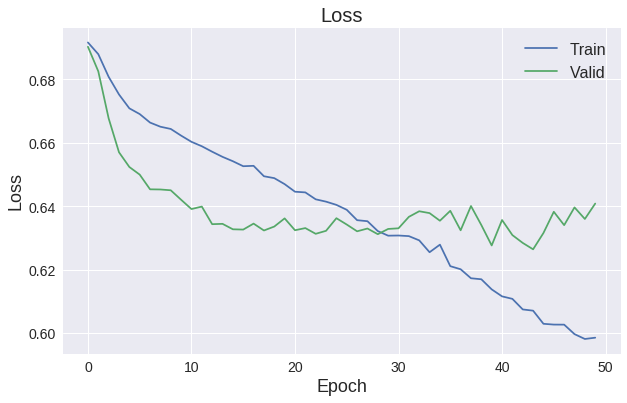

In [19]:
import evaluate

metrics = evaluate.metrics

train_metrics = pd.read_csv(RESULTS_PATH + 'train_hist.csv')
valid_metrics = pd.read_csv(RESULTS_PATH + 'valid_hist.csv')

for metric in list(metrics.keys()) + ['loss']:
    f, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.plot(train_metrics.index, train_metrics[metric], 'C0', label='Train')
    ax.plot(valid_metrics.index, valid_metrics[metric], 'C1', label='Valid')
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel(metric.capitalize())
    ax.set_title(metric.capitalize(), fontsize=20)
    
    ax.legend()
    legend = ax.legend(
        loc='best',
#         bbox_to_anchor=(1.2, 1.0),
        frameon=False,
        fancybox=False,
        ncol=1,
        fontsize=16
    )

    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(14)
    ax.xaxis.label.set_size(18)
    ax.yaxis.label.set_size(18)
    
    plt.show()


# Model Performance Evaluation

In [42]:
import torch
import utils
import model.data_loader as data_loader

metrics = evaluate.metrics
loss_fn = torch.nn.BCELoss()

# params = {'device': torch.device('cuda')}
params_path = '../experiments/00_baseline.json'
features_path = '../data/processed/baseline/features.json'

params = utils.Params()
params.load(params_path)
features = utils.Features()
features.load(features_path)

params['device'] = torch.device('cuda')

dataloaders = data_loader.fetch_dataloaders(data_dir='../data/processed/', features=features, params=params)

In [56]:
import evaluate

performance = {}
for phase in ['train', 'val', 'test']:
    dataloader = dataloaders[phase]
    phase_metrics, phase_confusion = evaluate.evaluate(model, loss_fn, dataloader, metrics, params)
    performance[phase] = phase_metrics
    
    print(f'{phase.capitalize()}:')
    for metric in phase_metrics.keys():
        print(f'\t{metric.capitalize()}: {phase_metrics[metric]:0.4f}')
    print(f'\tConfusion Matrix:')
    print(phase_confusion)
    print()

Train:
	Accuracy: 0.6756
	Auroc: 0.7462
	Loss: 0.6071
	Confusion Matrix:
[[34005. 11807.]
 [17917. 27895.]]

Val:
	Accuracy: 0.6106
	Auroc: 0.7144
	Loss: 0.6265
	Confusion Matrix:
[[372. 155.]
 [278. 249.]]

Test:
	Accuracy: 0.6353
	Auroc: 0.6906
	Loss: 0.6223
	Confusion Matrix:
[[390. 138.]
 [268. 260.]]



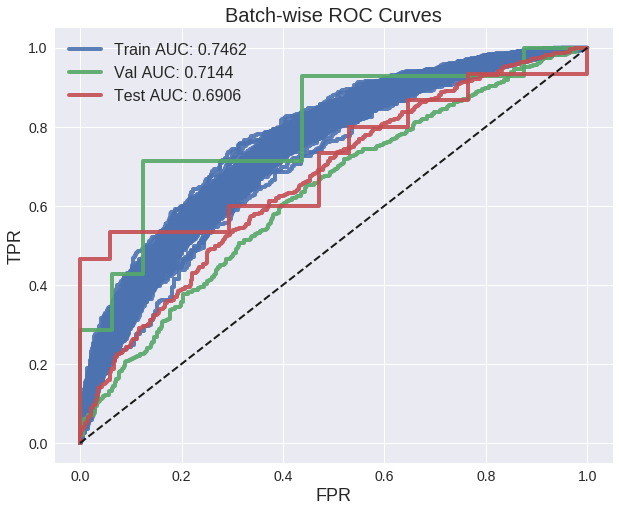

In [74]:
f, ax = plt.subplots(1, 1, figsize=(10, 8))
for i, phase in enumerate(['train', 'val', 'test']):
    dataloader = dataloaders[phase]
    phase_fpr, phase_tpr = evaluate.evaluate_roc(model, dataloader, params)
    
    # just take first batch
#     fpr = phase_fpr[0]
#     tpr = phase_tpr[0]
#     ax.plot(fpr, tpr, color=f'C{i}', lw=4, alpha=0.9, label=label)
    for j, (fpr, tpr) in enumerate(zip(phase_fpr, phase_tpr)):
        if j == 0:
            label = f"{phase.capitalize()} AUC: {performance[phase]['auroc']:0.4f}"
        else:
            label = None
        ax.plot(fpr, tpr, color=f'C{i}', lw=4, alpha=0.9, label=label)

ax.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')

ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.set_title('Batch-wise ROC Curves', fontsize=20)

ax.legend()
legend = ax.legend(
    loc='best',
#         bbox_to_anchor=(1.2, 1.0),
    frameon=False,
    fancybox=False,
    ncol=1,
    fontsize=16
)

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(14)
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)

plt.show()